In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from fenics import *
from utils.mesh_utils import get_square_f, get_L_mesh
from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver
from utils.colors import C2, C3, C5, CMAP
from utils.utils import progress_bar
SEED = 15

/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Function space
n = 64
mesh = UnitSquareMesh(n, n)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
print(f"K shape : {rsvd.N_b, rsvd.N}")

K shape : (256, 4225)


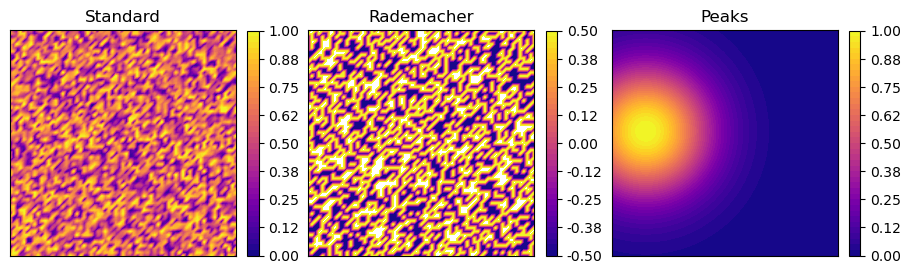

In [3]:
def plot_random_vectors(rsvd: MatrixFreeRSVD):
    V_h = rsvd.V_h
    f_standard = Function(V_h)
    f_rademacher = Function(V_h)
    f_peaks = Function(V_h)

    rng = np.random.default_rng(seed=SEED)

    f_standard.vector()[:] = rsvd.draw_random_vector('standard', rng)
    f_rademacher.vector()[:] = rsvd.draw_random_vector('rademacher', rng)
    f_peaks.vector()[:] = rsvd.draw_random_vector('peaks', rng, A=1, sigma=0.2)

    fig, axes = plt.subplots(1, 3, figsize=(9, 6), constrained_layout=True)
    axes = axes.flatten()

    names = ["Standard", "Rademacher", "Peaks"]
    sols = [f_standard, f_rademacher, f_peaks]
    for ax, func, name in zip(axes, sols, names):
        plt.sca(ax)
        p = plot(func, title=name, cmap=CMAP)
        fig.colorbar(p, ax=ax, format="%.2f", shrink=0.38)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()


plot_random_vectors(rsvd)

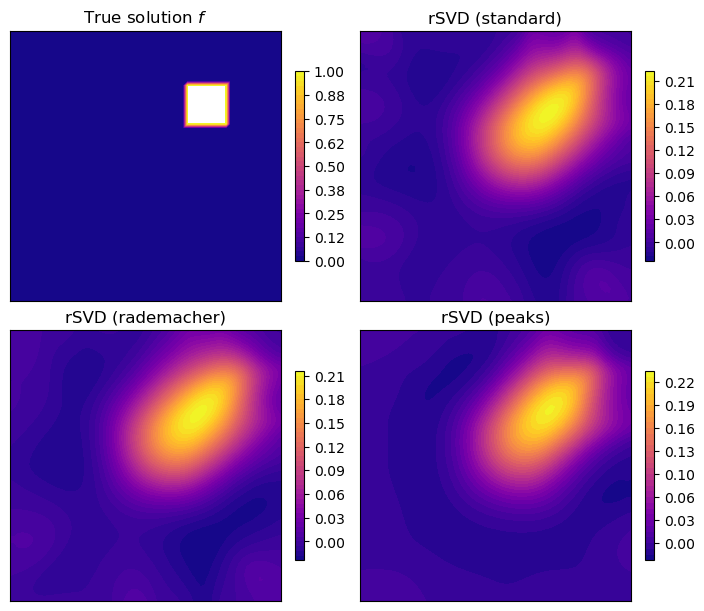

In [4]:
f = get_square_f(V_h, 0.65, 0.65)
x = f.vector().get_local()
y = rsvd.apply_K(x)

k = 15
solutions = [f]
distributions = ['standard', 'rademacher', 'peaks']
for distribution in distributions:

    Uk, Sk, VkT = rsvd.mf_rsvd(k=k, distribution=distribution, seed=SEED)
    w = get_approximate_W(Vk=VkT.T, M_dx=rsvd.M_dx)

    # Solve y = (K_k)(x)
    x_hat = tikhonov_solver(rsvd, W_diag=w, y=y, lambda_=1e-3)

    f_hat = Function(V_h)
    f_hat.vector()[:] = x_hat
    solutions.append(f_hat)


def plot_many_f(sols):
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
    axes = axes.flatten()

    names = [
        "True solution $f$",
        "rSVD (standard)",
        "rSVD (rademacher)",
        "rSVD (peaks)"
    ]
    for ax, func, name in zip(axes, sols, names):
        plt.sca(ax)
        p = plot(func, title=name, cmap=CMAP)
        fig.colorbar(p, ax=ax, format="%.2f", shrink=0.7)
        ax.set_xticks([])
        ax.set_yticks([])

plot_many_f(sols=solutions)

In [5]:
f = get_square_f(V_h, x0=0.65, y0=0.65)
x = f.vector().get_local()
y = rsvd.apply_K(x)
k_range = np.arange(5, 10)

def compute_distribution_errors(k_range, distribution, repeats):
    n_k = len(k_range)
    errors = np.zeros((repeats, n_k))
    for r in range(repeats):
        for i, k in enumerate(k_range):
            U, S, VT = rsvd.mf_rsvd(k=k, distribution=distribution)
            w = get_approximate_W(Vk=VT.T, M_dx=rsvd.M_dx)
            x_hat = tikhonov_solver(rsvd, W_diag=w, y=y, lambda_=1e-3)
            errors[r, i] = np.linalg.norm(x - x_hat)
            progress_bar(r * n_k + i + 1, n_k * repeats, end_text=f' ({distribution})')
    return errors

In [6]:
repeats = 100
k_lower, k_upper = 5, 50
k_range = np.arange(k_lower, k_upper)

file_name = f'../results/errors_k_{k_lower}_{k_upper}_r_{repeats}.npz'
if not os.path.exists(file_name):
    errors = {
        "standard": compute_distribution_errors(k_range, 'standard', repeats),
        "rademacher": compute_distribution_errors(k_range, 'rademacher', repeats),
        "peaks": compute_distribution_errors(k_range, 'peaks', repeats)
    }

    np.savez(file_name, **errors)
    print(f"Saved as {file_name}")

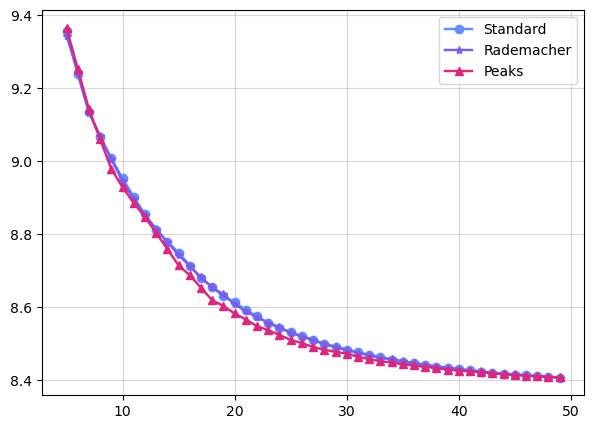

In [7]:
errors = np.load(file_name)
std_mean = np.mean(errors['standard'], axis=0)
rdm_mean = np.mean(errors['rademacher'], axis=0)
pks_mean = np.mean(errors['peaks'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(k_range, std_mean, '-o', c=C3[0], lw=1.75, label='Standard')
ax.plot(k_range, rdm_mean, '-*', c=C3[1], lw=1.75, label='Rademacher')
ax.plot(k_range, pks_mean, '-^', c=C3[2], lw=1.75, label='Peaks')

ax.grid(alpha=0.5)
ax.legend()
plt.show()

---
#### Trying different 'Peaks'

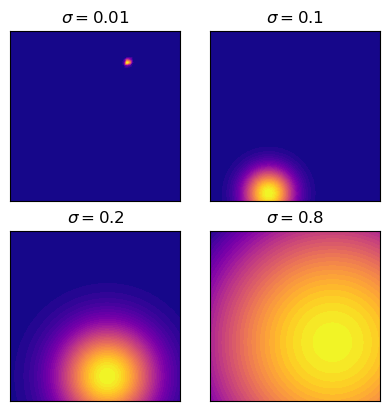

In [8]:
def plot_random_vectors(rsvd: MatrixFreeRSVD, A_list, sigma_list):
    V_h = rsvd.V_h
    rng = np.random.default_rng(seed=SEED)

    f_list = []
    for A, sigma in zip(A_list, sigma_list):
        f = Function(V_h)
        f.vector()[:] = rsvd.draw_random_vector('peaks', rng, A=A, sigma=sigma)
        f_list.append(f)


    fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=True)
    axes = axes.flatten()

    for ax, f, sigma in zip(axes, f_list, sigma_list):
        plt.sca(ax)
        p = plot(f, title=f"$\\sigma={sigma}$", cmap=CMAP)
        #fig.colorbar(p, ax=ax, format="%.2f", shrink=0.38)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

A_list = [1, 1, 1, 1]
sigma_list = [0.01, 0.1, 0.2, 0.8]
plot_random_vectors(rsvd, A_list, sigma_list)

In [9]:
repeats = 100
k_lower, k_upper = 5, 50
k_range = np.arange(k_lower, k_upper)

def compute_sigma_errors(k_range, sigma, repeats):
    n_k = len(k_range)
    errors = np.zeros((repeats, n_k))
    for r in range(repeats):
        for i, k in enumerate(k_range):
            U, S, VT = rsvd.mf_rsvd(k=k, distribution='peaks', sigma=sigma)
            w = get_approximate_W(Vk=VT.T, M_dx=rsvd.M_dx)
            x_hat = tikhonov_solver(rsvd, W_diag=w, y=y, lambda_=1e-3)
            errors[r, i] = np.linalg.norm(x - x_hat)
            progress_bar(r * n_k + i + 1, n_k * repeats, end_text=f' (sigma={sigma})')
    return errors


errors_peaks = []
for sigma in sigma_list:
    errors_peaks.append(compute_sigma_errors(k_range, sigma=sigma, repeats=repeats))
errors_sigma = np.array(errors_peaks)

[##############################] 4500/4500 (sigma=0.01)
[##############################] 4500/4500 (sigma=0.1)
[##############################] 4500/4500 (sigma=0.2)
[##############################] 4500/4500 (sigma=0.8)


In [10]:
file_name = f"../results/errors_sigma_k_{k_lower}_{k_upper}_r_{repeats}.npy"
if not os.path.exists(file_name):
    np.save(file_name, errors_sigma)
    print(f"Saved as {file_name}")

Saved as ../results/errors_sigma_k_5_50_r_100.npy


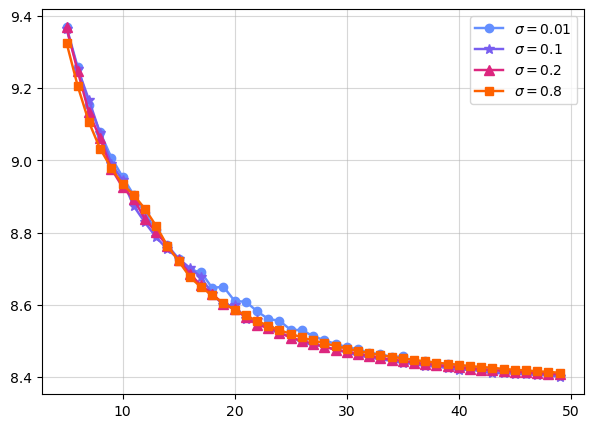

In [11]:
errors_sigma = np.load(file_name)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

shapes = ['o', '*', '^', 's']
sizes = [6, 7, 7, 6]
for i, (error_sigma, sigma) in enumerate(zip(errors_sigma, sigma_list)):
    ax.plot(k_range, np.mean(error_sigma, axis=0),
            c=C5[i], lw=1.75, label=f"$\\sigma={sigma}$", marker=shapes[i],
            ms = sizes[i]
            )


ax.grid(alpha=0.5)
ax.legend()
plt.show()